In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras import layers
from keras.applications.resnet50 import preprocess_input
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd

Using TensorFlow backend.


In [2]:
from keras import layers

In [3]:
img_width, img_height = 300, 400
vgg16_model = applications.ResNet50(weights= 'imagenet', include_top =False, input_shape = (img_height, img_width,3))

x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(1)(x)
predictions = layers.ReLU(max_value=40)(x)

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [4]:
model = Model(inputs = vgg16_model.inputs, outputs = predictions)

In [5]:
for layer in vgg16_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='mse')

In [6]:
callback_list = [
    ModelCheckpoint('./save_models/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5')
]

In [7]:
train_path ='images/train'
test_path ='images/test'
val_path = 'images/val'

In [8]:
def load_data(path):
    file_list = os.listdir(path)
    file_list.sort()
    images = []
    labels = []
        
    for i in range(len(file_list)):
        images.append(cv2.imread(path +'/'+ file_list[i]))
        labels.append([int(file_list[i].split('.')[0].split('_')[1])])
    images = preprocess_input(np.array(images))
    labels = np.array(labels)
    return images, labels
    

In [9]:
train_images, train_labels = load_data(train_path)
test_images, test_labels = load_data(test_path)
val_images, val_labels = load_data(val_path)

In [48]:
hist = model.fit(train_images,train_labels,
                 batch_size=32,epochs=2,
                 validation_data=(val_images,val_labels),
                 callbacks= callback_list)

Train on 703 samples, validate on 65 samples
Epoch 1/2
703/703 [==============================] - 6s 8ms/step - loss: 1.8420 - val_loss: 4.7867
Epoch 2/2
703/703 [==============================] - 6s 8ms/step - loss: 0.5700 - val_loss: 2.2105


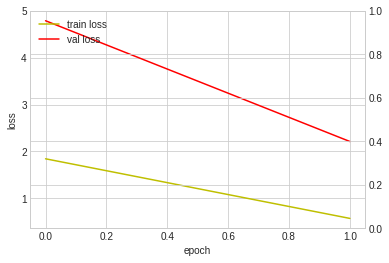

In [49]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

In [50]:
predict = model.predict(test_images)

In [51]:
df = pd.DataFrame(data={'label': test_labels.flatten(), 'prediction': predict.flatten(), 'Error': test_labels.flatten() -predict.flatten()})


In [52]:
df

,Error,label,prediction
0,-1.084847,0,1.084847
1,-1.038832,1,2.038832
2,-0.295842,2,2.295842
3,-0.960963,3,3.960963
4,-0.144135,4,4.144135
5,-0.428038,5,5.428038
6,-0.246172,6,6.246172
7,-0.514411,7,7.514411
8,0.239089,8,7.760911
9,-0.224782,9,9.224782


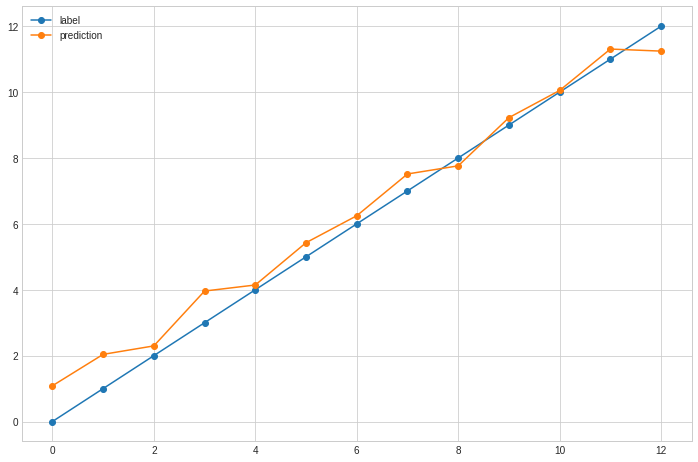

In [53]:
plt.style.use('seaborn-whitegrid')
df[['label', 'prediction']].plot(figsize=(12, 8), style='o-')

In [55]:
print(np.sqrt(np.mean(df.Error ** 2)))

0.593077225644


In [ ]:
model.summary()